<h1>Summary</h1>
<p>I would like to determine if football fan channels 'profit' from the under-performance of their team. As with many business problems, we can't directly measure our target. In this case for example, we don't know the revenue and costs for making these videos (among other things). Therefore I will assume that 'engagement' is correlated with profit and use 'engagement' as a proxy. The type of engagement we are concerned with are views, likes, and comments.</p>

<p> Some questions I would like to answer include:
    <ul>
        <li>Does engagement change with time?</li>
        <li>Do results (win/loss) affect engagement?</li>
        <li>What is the ratio of wins-losses-draws?</li>
    </ul>

</p>


In [56]:
import pandas as pd

Read in data

In [57]:
channel_name = 'tus'
videos = pd.read_csv(f'../data/{channel_name}/{channel_name}_preprocess.csv')

Peek at head of data

In [58]:
videos.head()

,title,date,views,likes,comments,team_score,opponent_score
0,RANGNICK GONE! Man Utd Transfer News,2022-05-29,59160,6057,200.0,NaN,NaN
1,TEN HAG'S 200 MILLION Transfer Request! Man Ut...,2022-05-29,145954,5766,150.0,NaN,NaN
2,TEN HAG'S DE JONG Back Up Plan! Man Utd Transf...,2022-05-28,136669,4374,250.0,NaN,NaN
3,United AGREE DE JONG FEE! TEN HAG Persuades FR...,2022-05-28,278585,9293,757.0,NaN,NaN
4,TEN HAG'S First SIGNING! Man Utd Transfer News,2022-05-27,251850,7049,348.0,NaN,NaN


In [59]:
len(videos), len(videos.dropna())

(2357, 659)

<h3>Function to calculate aggregate values</h3>

In [60]:
def channel_statistics(channel_videos: pd.DataFrame) -> pd.DataFrame:
    '''
    Aggregate (sum) likes, comments, and views per day
    create column result to specify win/loss/draw
        
    '''
    # drop nans as these are not match day videos
    channel_matches = channel_videos[channel_videos['team_score'].notna()]
    
    # aggregate statistics per day
    channel_stats = channel_matches.groupby('date').agg({'title': 'first',
                                                    'views': 'sum',
                                                    'likes': 'sum',
                                                    'comments': 'sum',
                                                    'team_score': 'first',
                                                    'opponent_score': 'first'})
    
    # flag for wins, draws, and losses
    channel_stats.loc[channel_stats['team_score'] > channel_stats['opponent_score'],'result'] = 'win'
    channel_stats.loc[channel_stats['team_score'] < channel_stats['opponent_score'],'result'] =  'loss'
    channel_stats.loc[channel_stats['team_score'] == channel_stats['opponent_score'],'result'] = 'draw'
    
    return channel_stats
    
    

In [61]:
channel_stats = channel_statistics(videos)

In [62]:
len(channel_stats)

242

<font color='blue'>What is the win:draw:loss ratio?</font>

In [63]:
channel_stats['result'].value_counts(normalize=True)

win     0.450413
loss    0.322314
draw    0.227273
Name: result, dtype: float64

In [64]:
channel_stats['result'].value_counts()

win     109
loss     78
draw     55
Name: result, dtype: int64

<hr>
<h3>Visualisation of engagement over time</h3>

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
color_dict = {'win' :'green', 'loss': 'red', 'draw': 'blue'}

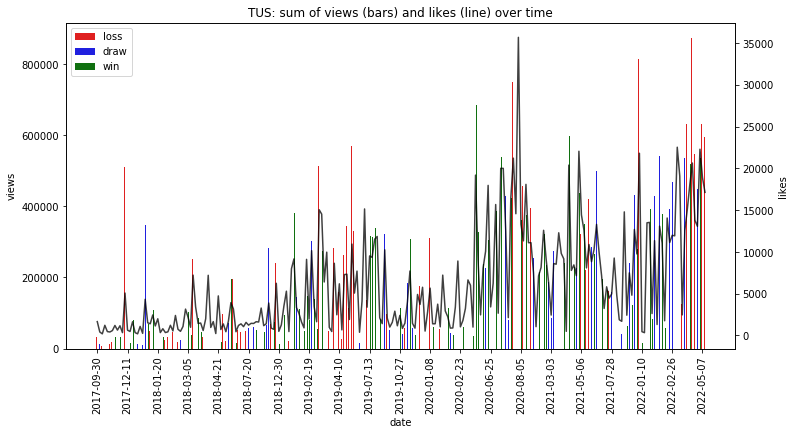

In [67]:
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_title(f'{channel_name.upper()}: sum of views (bars) and likes (line) over time')

# bar plot of views
sns.barplot(data=channel_stats.reset_index(), x='date', y='views', hue='result', palette=color_dict, ax=ax1)
ax2 = ax1.twinx()

# line plot of likes
sns.lineplot(data=channel_stats.reset_index(), x='date', y='likes', color='k', alpha=0.75, ax=ax2)
#ax2.lines[0].set_linestyle("--")

# limit number of xticks displayed
xticks=ax1.xaxis.get_major_ticks()
for i in range(len(xticks)):
    xticks[i].set_visible(False)
    
for i in range(0,len(xticks),12):
    xticks[i].set_visible(True)    
    
        
        
ax1.legend(loc='upper left')
ax1.tick_params(axis='x', rotation=90)

# save fig
plt.savefig(f'{channel_name}.png')

<font color='blue'> I can see that there is an increase in views and likes with time. This makes sense as the channels get more popular and gain more subscribers/viewers </font>

TODO: investigate 'outliers'

<hr>
<h3>Summary statistics</h3>
<p>Investigate descriptive statistics for wins, losses, and draws</p>

In [68]:
summary = channel_stats.copy()

In [69]:
stats = ['min', 'max', 'mean', 'median']

In [70]:
results = summary.groupby('result').agg({'views': stats,
                            'likes': stats,
                           'comments': stats}).transpose()

<font color='blue'>Do results affect engagement?</font>

In [71]:
results

result                    draw           loss            win
views    min      11003.000000    6175.000000   10682.000000
         max     560487.000000  872637.000000  684052.000000
         mean    210955.545455  231980.794872  190234.697248
         median  188398.000000  146680.000000  123320.000000
likes    min        192.000000     189.000000     329.000000
         max      14563.000000   21801.000000   35676.000000
         mean      5632.509091    5586.294872    6556.183486
         median    4110.000000    3155.500000    3394.000000
comments min         27.000000      22.000000      32.000000
         max       2888.000000    4450.000000    2018.000000
         mean       761.200000     858.871795     517.036697
         median     654.000000     597.500000     353.000000

save results

In [72]:
results.to_csv(f'{channel_name}_summary_statistics.csv')

In [73]:
channel_stats.to_csv(f'{channel_name}_performance_statistics.csv')